# Zero-Shot Citation Hallucination Detection

**Scores:** ICS · PAS · PFS · BAS

| Score | Full Name | What it measures |
|-------|-----------|------------------|
| **ICS** | Internal Consistency Score | Cosine sim between citation hidden state and essay context |
| **PAS** | Pathway Alignment Score | Cosine sim between attention (read) and FFN (recall) pathways |
| **PFS** | Parametric Force Score | Magnitude of the hidden state update (FFN push) |
| **BAS** | BOS Attention Score | Attention from citation token to BOS token (position 0) |

**Workflow:** Generation and scoring are **fully decoupled**.
1. Generate essays one-by-one → each saved to JSONL immediately (crash-safe)
2. Push to GitHub → `git pull` on your PC
3. (Optional: restart runtime) Load saved essays → Score → Push results

---
## 1. Setup

In [10]:
!pip install -q transformers accelerate requests tqdm
import torch, gc, os, json, time
assert torch.cuda.is_available(), 'Switch to GPU runtime!'
print(f"GPU: {torch.cuda.get_device_name(0)}")

GPU: Tesla T4


In [11]:
from huggingface_hub import login
login(token="")  # <-- paste your HF token

In [12]:
# Clone repo (has prompts, will store results)
REPO_DIR = "/content/soppery"
if not os.path.exists(REPO_DIR):
    !git clone https://github.com/floating-reeds/soppery.git {REPO_DIR}
else:
    !cd {REPO_DIR} && git pull
os.chdir(REPO_DIR)

# Mount Google Drive for auto-saving results
from google.colab import drive
drive.mount('/content/drive')
DRIVE_BACKUP = '/content/drive/MyDrive/soppery_results'
os.makedirs(DRIVE_BACKUP, exist_ok=True)
print(f"Working in: {os.getcwd()}")
print(f"Drive backup: {DRIVE_BACKUP}")

Already up to date.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working in: /content/soppery
Drive backup: /content/drive/MyDrive/soppery_results


In [13]:
from datetime import datetime
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M")

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
MAX_NEW_TOKENS = 512
TEMPERATURE = 0.7
SCORE_MAX_LEN = 512

---
## 2. Load Prompts from Repo

In [14]:
all_prompts = []
for fname in sorted(os.listdir('data/prompts')):
    if fname.endswith('.json'):
        with open(f'data/prompts/{fname}') as f:
            prompts = json.load(f)
        all_prompts.extend(prompts)
        print(f'  {fname}: {len(prompts)} prompts')
print(f'\nTotal: {len(all_prompts)} prompts')

  scientific.json: 150 prompts

Total: 150 prompts


---
## 3. Citation Extraction

In [15]:
import re
from dataclasses import dataclass, asdict
from typing import List, Optional

@dataclass
class Citation:
    raw_text: str
    start_pos: int
    end_pos: int
    extracted_authors: Optional[List[str]] = None
    extracted_year: Optional[int] = None
    citation_type: str = "academic"

PATTERNS = [
    re.compile(r'\(([A-Z][a-z]+(?:\s+(?:et\s+al\.?|&|and)\s+[A-Z][a-z]+)*,?\s*\d{4}[a-z]?)\)'),
    re.compile(r'([A-Z][a-z]+(?:\s+et\s+al\.?))\s*\((\d{4}[a-z]?)\)'),
    re.compile(r'([A-Z][a-z]+(?:\s+(?:and|&)\s+[A-Z][a-z]+)?)\s*\((\d{4})\)'),
    re.compile(r'["\u201c]([^"\u201d]{10,100})["\u201d]\s*\((\d{4})\)'),
    re.compile(r'([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\s+v\.?\s+[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\s*\((\d{4})\)'),
]

def extract_citations(text):
    cites, seen = [], set()
    for pat in PATTERNS:
        for m in pat.finditer(text):
            s, e = m.span()
            if any(s <= p <= e for p in seen): continue
            seen.update(range(s, e+1))
            c = Citation(raw_text=m.group(0), start_pos=s, end_pos=e)
            yr = re.search(r'\d{4}', m.group(0))
            if yr: c.extracted_year = int(yr.group())
            au = re.search(r'([A-Z][a-z]+)', m.group(0))
            if au: c.extracted_authors = [au.group(1)]
            cites.append(c)
    return cites

# Test
t = extract_citations('Vaswani et al. (2017) proposed Transformers. Also see (Devlin et al., 2019).')
print(f'Test: {len(t)} citations: {", ".join(c.raw_text for c in t)}')

Test: 1 citations: Vaswani et al. (2017)


---
## 4. Generate ALL Essays (Incremental Save)

**Crash-safe:** Each essay is appended to a `.jsonl` file immediately after generation.
If Colab disconnects, you keep everything generated so far.
On restart, it **skips already-generated prompts** automatically.

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

print(f'Loading {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=torch.float16, device_map='auto')
if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
print(f'Loaded. {model.config.num_hidden_layers} layers, {model.config.num_attention_heads} heads')

Loading meta-llama/Llama-3.2-3B-Instruct...


Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

Loaded. 28 layers, 24 heads


In [17]:
SYSTEM_PROMPTS = {
    'scientific': """You are an academic researcher writing a concise research summary.
Write a brief, focused response (around 300-400 words).
You MUST include proper academic citations throughout.
Format: Author et al. (Year) or (Author et al., Year).
Every major claim MUST have a citation with real author names and years.
Example: Vaswani et al. (2017) introduced the Transformer architecture.""",
}

# Output file — one JSON object per line (append-safe)
os.makedirs('data/essays', exist_ok=True)
model_short = MODEL_NAME.split('/')[-1]
ESSAY_FILE = f'data/essays/{model_short}_{RUN_ID}_essays.jsonl'

# Load already-generated IDs (for resume after crash)
done_ids = set()
if os.path.exists(ESSAY_FILE):
    with open(ESSAY_FILE) as f:
        for line in f:
            try: done_ids.add(json.loads(line)['prompt_id'])
            except: pass
    print(f'Resuming: {len(done_ids)} essays already generated')

remaining = [p for p in all_prompts if p['id'] not in done_ids]
print(f'To generate: {len(remaining)} essays')

Resuming: 119 essays already generated
To generate: 31 essays


In [18]:
import shutil

def save_to_drive():
    """Copy essay file to Google Drive after each generation."""
    try:
        shutil.copy2(ESSAY_FILE, f'{DRIVE_BACKUP}/{os.path.basename(ESSAY_FILE)}')
    except Exception:
        pass  # Don't let Drive errors stop generation

# Generate one essay at a time, save immediately
total_new_cites = 0

for i, p in enumerate(tqdm(remaining, desc='Generating')):
    sys_prompt = SYSTEM_PROMPTS.get(p['domain'], SYSTEM_PROMPTS['scientific'])
    messages = [{"role": "system", "content": sys_prompt}, {"role": "user", "content": p["prompt"]}]

    try:
        formatted = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    except:
        formatted = f"{sys_prompt}\n\nRequest: {p['prompt']}\n\nResponse:"

    inputs = tokenizer(formatted, return_tensors='pt', truncation=True, max_length=2048).to('cuda')
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=MAX_NEW_TOKENS, temperature=TEMPERATURE,
                             top_p=0.9, do_sample=True, pad_token_id=tokenizer.pad_token_id)

    response = tokenizer.decode(out[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
    cites = extract_citations(response)
    total_new_cites += len(cites)

    essay = {
        'prompt_id': p['id'], 'domain': p['domain'], 'prompt': p['prompt'],
        'model_name': MODEL_NAME, 'response': response,
        'citations': [asdict(c) for c in cites],
        'num_citations': len(cites),
    }

    # Append immediately — crash-safe
    with open(ESSAY_FILE, 'a') as f:
        f.write(json.dumps(essay) + '\n')

    # Backup to Google Drive after each essay
    save_to_drive()

    if (i+1) % 10 == 0:
        print(f'  [{i+1}/{len(remaining)}] {total_new_cites} new citations')

print(f'\nDone! Generated {len(remaining)} essays with {total_new_cites} citations')
print(f'All saved to: {ESSAY_FILE}')
print(f'Drive backup: {DRIVE_BACKUP}/{os.path.basename(ESSAY_FILE)}')

Generating:  32%|███▏      | 10/31 [04:37<08:25, 24.09s/it]

  [10/31] 32 new citations


Generating:  65%|██████▍   | 20/31 [08:25<04:10, 22.81s/it]

  [20/31] 65 new citations


Generating:  97%|█████████▋| 30/31 [12:13<00:22, 22.77s/it]

  [30/31] 87 new citations


Generating: 100%|██████████| 31/31 [12:36<00:00, 24.41s/it]


Done! Generated 31 essays with 90 citations
All saved to: data/essays/Llama-3.2-3B-Instruct_essays.jsonl
Drive backup: /content/drive/MyDrive/soppery_results/Llama-3.2-3B-Instruct_essays.jsonl


In [19]:
# Copy essays to Google Drive
import shutil
shutil.copy2(ESSAY_FILE, f'{DRIVE_BACKUP}/{os.path.basename(ESSAY_FILE)}')
print(f'Essays backed up to Drive: {DRIVE_BACKUP}/')
print('Check Google Drive > MyDrive > soppery_results')

Essays backed up to Drive: /content/drive/MyDrive/soppery_results/
Check Google Drive > MyDrive > soppery_results


In [20]:
# Free GPU for scoring later
del model
gc.collect(); torch.cuda.empty_cache()
print(f'VRAM freed: {torch.cuda.memory_allocated()/1e9:.2f} GB in use')

VRAM freed: 6.48 GB in use


---
## 5. Citation Verification

**What causes `unverified`:**
- API timeout / rate-limiting (HTTP 429) after retries
- Citation has no extractable author or year (regex found a partial match)
- Both Semantic Scholar AND CrossRef are unreachable

**How we minimize it:** Retry on failure, CrossRef fallback, broader search queries.

If a citation is still `unverified`, it's excluded from scoring (only `real` vs `fabricated` are scored).

In [21]:
import requests

def search_ss(query, retries=2):
    for _ in range(retries):
        try:
            r = requests.get('https://api.semanticscholar.org/graph/v1/paper/search',
                             params={'query': query, 'limit': 5, 'fields': 'title,authors,year'}, timeout=15)
            if r.status_code == 429: time.sleep(3); continue
            if r.status_code == 200: return r.json().get('data', [])
        except: time.sleep(2)
    return None

def search_crossref(query):
    try:
        r = requests.get('https://api.crossref.org/works', params={'query': query, 'rows': 3}, timeout=15)
        if r.status_code == 200:
            return [{'title': it.get('title',[''])[0],
                     'year': it.get('published',{}).get('date-parts',[[None]])[0][0],
                     'authors': [{'name': f"{a.get('given','')} {a.get('family','')}"} for a in it.get('author',[])]}
                    for it in r.json().get('message',{}).get('items',[])]
    except: pass
    return []

def verify_citation(authors, year, raw_text=''):
    parts = []
    if authors: parts.append(authors[0])
    if year: parts.append(str(year))
    if not parts:
        words = [w for w in raw_text.split() if len(w) > 2][:3]
        if words: parts = words
    if not parts: return 'unverified', 0.0, None
    query = ' '.join(parts)
    papers = search_ss(query)
    if papers is None:
        papers = search_crossref(query)
        if not papers: return 'unverified', 0.0, None
    if not papers: return 'fabricated', 0.75, None
    for p in papers:
        yr_ok = (year is None) or (p.get('year') == year)
        au_ok = True
        if authors:
            last = authors[0].split()[-1].lower()
            au_ok = any(last in a.get('name','').lower() for a in p.get('authors',[]))
        if yr_ok and au_ok: return 'real', 0.9, p.get('title')
    return 'fabricated', 0.6, None

print('Verification functions defined (SS + CrossRef fallback)')

Verification functions defined (SS + CrossRef fallback)


In [22]:
# Load all generated essays
essays = []
with open(ESSAY_FILE) as f:
    for line in f:
        try: essays.append(json.loads(line))
        except: pass
print(f'Loaded {len(essays)} essays')

# Verify
stats = {'real': 0, 'fabricated': 0, 'unverified': 0}
for essay in tqdm(essays, desc='Verifying'):
    for c in essay['citations']:
        if 'label' in c: stats[c['label']] += 1; continue  # Skip already verified
        label, conf, matched = verify_citation(c.get('extracted_authors'), c.get('extracted_year'), c.get('raw_text',''))
        c['label'] = label; c['confidence'] = conf; c['matched_title'] = matched
        stats[label] += 1
        time.sleep(0.5)

total = sum(stats.values())
print(f'\nVerification ({total} citations):')
for k, v in stats.items(): print(f'  {k}: {v} ({v/total*100:.0f}%)' if total else f'  {k}: {v}')

# Overwrite JSONL with verified versions
with open(ESSAY_FILE, 'w') as f:
    for e in essays: f.write(json.dumps(e) + '\n')
print(f'Saved verified essays')

Loaded 150 essays


Verifying: 100%|██████████| 150/150 [49:29<00:00, 19.80s/it]


Verification (478 citations):
  real: 369 (77%)
  fabricated: 109 (23%)
  unverified: 0 (0%)
Saved verified essays


---
## 6. Mechanistic Scoring (ICS, PAS, PFS, BAS)

**You can run this anytime** — essays are loaded from the saved JSONL file.
Generation and scoring are completely independent.

⚠️ If you just ran generation, **restart the runtime** first to free VRAM,
then re-run cells 1–3 (setup/login/clone) and skip to here.

In [23]:
# Load essays (works after runtime restart)
import json, os, gc, torch, time
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"
SCORE_MAX_LEN = 512
os.chdir('/content/soppery')
# Find the most recent essay file for this model
model_short = MODEL_NAME.split('/')[-1]
import glob
essay_files = sorted(glob.glob(f'data/essays/{model_short}_*_essays.jsonl'))
if essay_files:
    ESSAY_FILE = essay_files[-1]  # most recent by filename
else:
    ESSAY_FILE = f'data/essays/{model_short}_essays.jsonl'  # fallback

essays = []
with open(ESSAY_FILE) as f:
    for line in f:
        try: essays.append(json.loads(line))
        except: pass

scorable = [e for e in essays if any(c.get('label') in ('real','fabricated') for c in e.get('citations',[]))]
print(f'Loaded {len(essays)} essays, {len(scorable)} have real/fabricated citations')

print(f'Loading {MODEL_NAME} with eager attention...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
scorer = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16, device_map='auto', attn_implementation='eager')
scorer.eval()
NL = scorer.config.num_hidden_layers
print(f'Ready: {NL} layers, VRAM: {torch.cuda.memory_allocated()/1e9:.1f} GB')

Loaded 150 essays, 129 have real/fabricated citations
Loading meta-llama/Llama-3.2-3B-Instruct with eager attention...


Loading weights:   0%|          | 0/254 [00:00<?, ?it/s]

Ready: 28 layers, VRAM: 12.9 GB


In [24]:
# --- HOOKS: separate attention vs FFN pathways ---
activation_cache = {}
def get_activation(name):
    def hook(model, input, output):
        activation_cache[name] = output[0].detach()
    return hook

for i in range(NL):
    scorer.model.layers[i].post_attention_layernorm.register_forward_hook(get_activation(f'layer_{i}_mid'))

def find_cite_toks(essay, tok, ml):
    txt = essay['prompt'] + essay['response']
    enc = tok(txt, return_tensors='pt', return_offsets_mapping=True, truncation=True, max_length=ml)
    offs = enc.offset_mapping[0].tolist()
    plen = len(tok(essay['prompt'], return_tensors='pt').input_ids[0])
    res = []
    for c in essay['citations']:
        if c.get('label') not in ('real','fabricated'): continue
        cs = c['start_pos'] + len(essay['prompt'])
        for i,(ts,te) in enumerate(offs):
            if ts <= cs < te: res.append((c,i)); break
    return enc, plen, res

all_scores = []
for essay in tqdm(scorable, desc='Scoring'):
    enc, plen, cps = find_cite_toks(essay, tokenizer, SCORE_MAX_LEN)
    if not cps: continue

    try:
        activation_cache = {}
        with torch.no_grad():
            out = scorer(input_ids=enc.input_ids.cuda(),
                         output_hidden_states=True, output_attentions=True, return_dict=True)
        hs = tuple(h.cpu() for h in out.hidden_states)
        attn = torch.stack(out.attentions).squeeze(1).cpu()
        del out; torch.cuda.empty_cache()
    except Exception as e:
        print(f'  Error {essay["prompt_id"]}: {e}'); continue

    for c, tp in cps:
        ics, pas, pfs, bas = [], [], [], []
        for l in range(NL):
            pre  = hs[l][0, tp].cuda()
            mid  = activation_cache[f'layer_{l}_mid'][0, tp].cuda()
            post = hs[l+1][0, tp].cuda()

            v_attn = mid - pre
            v_ffn  = post - mid

            # ICS: attention-weighted context similarity
            if l < attn.shape[0]:
                a = attn[l, :, tp, plen:tp].cuda()
                if a.shape[-1] > 0:
                    a = a / (a.sum(dim=-1, keepdim=True) + 1e-9)
                    a = a.to(dtype=torch.float16)
                    ctx = torch.matmul(a, hs[l+1][0, plen:tp].cuda())
                    ics_val = F.cosine_similarity(ctx, post.unsqueeze(0).expand_as(ctx), dim=-1).mean().item()
                else: ics_val = 0.0
            else: ics_val = 0.0
            ics.append(ics_val)

            # PAS: cosine sim between attn and FFN pathways
            if torch.norm(v_attn) > 1e-6 and torch.norm(v_ffn) > 1e-6:
                pas.append(F.cosine_similarity(v_attn.unsqueeze(0), v_ffn.unsqueeze(0)).item())
            else:
                pas.append(0.0)

            # PFS: FFN force magnitude
            pfs.append(torch.norm(v_ffn).item())

            # BAS: attention to BOS
            if l < attn.shape[0]:
                bas.append(attn[l, :, tp, 0].mean().item())
            else: bas.append(0.0)

        all_scores.append({
            'ics_scores': ics, 'ics_mean': sum(ics)/len(ics), 'ics_final': ics[-1],
            'pas_scores': pas, 'pas_mean': sum(pas)/len(pas), 'pas_final': pas[-1],
            'pfs_scores': pfs, 'pfs_mean': sum(pfs)/len(pfs), 'pfs_final': pfs[-1],
            'bas_scores': bas, 'bas_mean': sum(bas)/len(bas),
            'prompt_id': essay['prompt_id'], 'domain': essay['domain'],
            'label': c.get('label','?'), 'citation': c['raw_text'],
        })
    del hs, attn; torch.cuda.empty_cache()

print(f'\nScored {len(all_scores)} citations')

Scoring: 100%|██████████| 129/129 [01:34<00:00,  1.37it/s]


Scored 472 citations


---
## 7. Results

In [25]:
import pandas as pd

if all_scores:
    df = pd.DataFrame(all_scores)
    cols = [c for c in ['prompt_id','domain','citation','label','ics_mean','pas_mean','pfs_mean','bas_mean'] if c in df.columns]
    display(df[cols].round(4))
    print('\n=== Averages by Label ===')
    num = [c for c in ['ics_mean','pas_mean','pfs_mean','bas_mean'] if c in df.columns]
    if len(df['label'].unique()) > 1:
        print(df.groupby('label')[num].mean().round(4).to_string())
    else:
        print(f'All: {df["label"].iloc[0]}')
        print(df[num].describe().round(4).to_string())
else:
    print('No citations scored.')

,prompt_id,domain,citation,label,ics_mean,pas_mean,pfs_mean,bas_mean
0,sci_001,scientific,Vaswani et al. (2017),fabricated,0.3628,-0.8654,15.6214,0.8280
1,sci_001,scientific,Vaswani et al. (2017),fabricated,0.4208,-0.8738,16.4644,0.7110
2,sci_001,scientific,Vaswani et al. (2017),fabricated,0.4538,-0.8595,15.3030,0.6973
3,sci_001,scientific,Devlin et al. (2019),fabricated,0.4329,-0.8809,16.0421,0.8050
4,sci_001,scientific,Vaswani et al. (2019),fabricated,0.4207,-0.8437,15.2739,0.7297
...,...,...,...,...,...,...,...,...
467,sci_149,scientific,Liu et al. (2018),real,0.4608,-0.8912,16.5888,0.7681
468,sci_149,scientific,Chua (1975),real,0.4297,-0.8697,14.6922,0.8389
469,sci_150,scientific,"(Bravyi & Gosset, 2015)",real,0.4541,-0.8580,16.8986,0.7047
470,sci_150,scientific,"(Gottesman & Chuang, 1999)",real,0.4933,-0.8615,17.9005,0.6864



=== Averages by Label ===
            ics_mean  pas_mean  pfs_mean  bas_mean
label                                             
fabricated    0.4627   -0.8605   16.1122    0.7445
real          0.4721   -0.8583   16.3862    0.7215


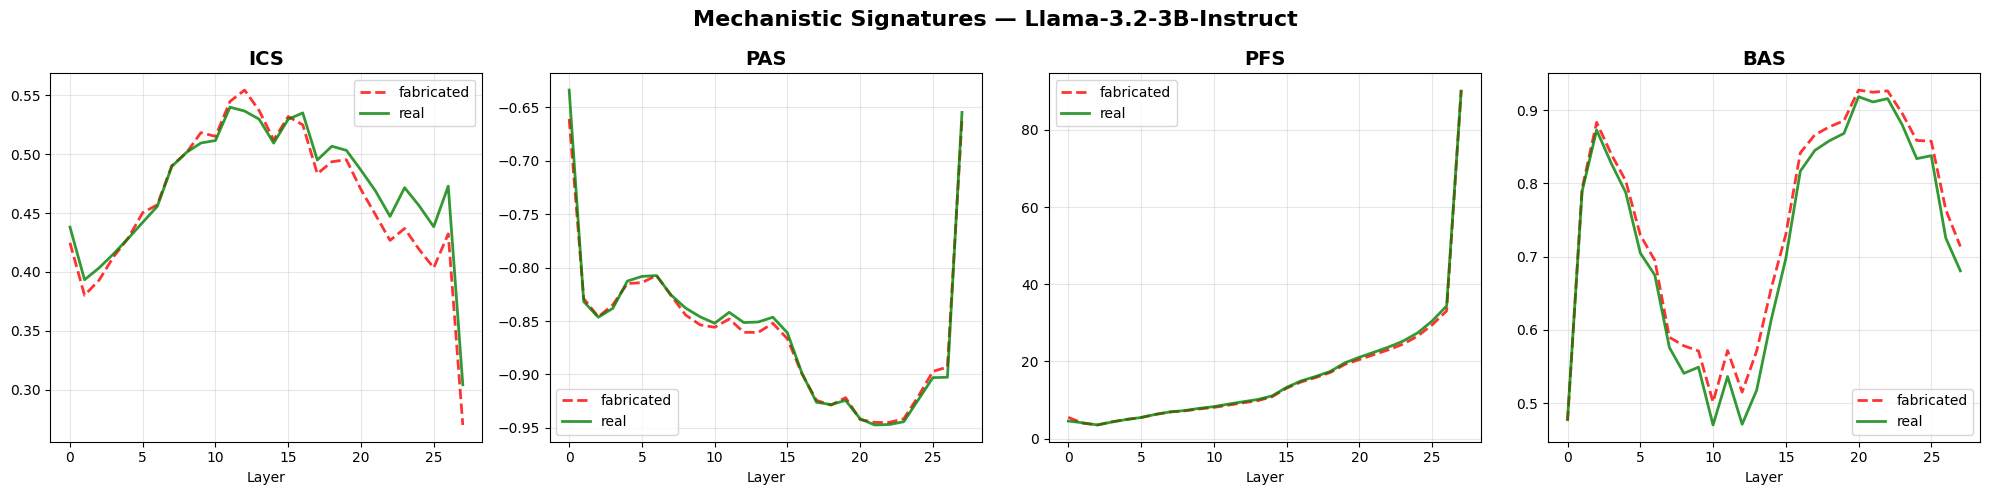

In [26]:
import matplotlib.pyplot as plt

if all_scores and len(df['label'].unique()) > 1:
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for ax, (key, title) in zip(axes, [('ics_scores','ICS'),('pas_scores','PAS'),('pfs_scores','PFS'),('bas_scores','BAS')]):
        for label in sorted(df['label'].unique()):
            sub = df[df['label']==label]
            means = []
            for l in range(NL):
                vals = [s[l] for s in sub[key] if len(s)>l]
                means.append(sum(vals)/len(vals) if vals else 0)
            color = {'real':'green','fabricated':'red'}.get(label,'gray')
            style = '--' if label == 'fabricated' else '-'
            ax.plot(range(NL), means, label=label, color=color, alpha=0.8, lw=2, linestyle=style)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Layer'); ax.legend(); ax.grid(True, alpha=0.3)
    plt.suptitle(f'Mechanistic Signatures — {MODEL_NAME.split("/")[-1]}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    os.makedirs('data/results', exist_ok=True)
    plt.savefig('data/results/layer_scores.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Need both real and fabricated citations for comparison plots')

In [27]:
# Save scores & copy to Google Drive
import shutil
os.makedirs('data/results', exist_ok=True)
sc_out = [{k: ([float(x) for x in v] if isinstance(v, list) else v) for k, v in s.items()} for s in all_scores]
scores_file = f'data/results/{MODEL_NAME.split("/")[-1]}_scores.json'
with open(scores_file, 'w') as f: json.dump(sc_out, f, indent=2)
with open(ESSAY_FILE, 'w') as f:
    for e in essays: f.write(json.dumps(e) + '\n')

# Copy everything to Drive
for src_file in [scores_file, ESSAY_FILE, 'data/results/layer_scores.png']:
    if os.path.exists(src_file):
        shutil.copy2(src_file, f'{DRIVE_BACKUP}/{os.path.basename(src_file)}')
print(f'All results saved to Drive: {DRIVE_BACKUP}/')
print('Download from Google Drive > MyDrive > soppery_results')

All results saved to Drive: /content/drive/MyDrive/soppery_results/
Download from Google Drive > MyDrive > soppery_results


---
## 8. Interpreting the Graphs

Here's what to look for in each plot:

### ICS (Internal Consistency Score)
- Measures how much the citation "fits" with the surrounding essay text
- **Expected:** Real citations should have **higher ICS** (more consistent with context) in later layers where semantic meaning is encoded
- **If real ≈ fabricated:** The model generates both types with similar internal consistency — it doesn't "know" the citation is fake at the representation level

### PAS (Pathway Alignment Score)
- Measures internal agreement between attention (what the model reads) and FFN (what it recalls from parameters)
- **Expected:** Fabricated citations should show **higher PAS** (more internal conflict) in middle layers where factual knowledge is stored
- **If both spike in early layers:** The early layers are doing general token processing — the interesting signal is in **layers 10–20** for a 28-layer model

### PFS (Parametric Force Score)  
- Raw magnitude of the hidden state update — how hard the FFN is "pushing"
- **Expected:** Fabricated citations need stronger parametric force since they aren't grounded in real knowledge
- **If similar:** The model applies similar computational effort to both types

### BAS (BOS Attention Score)
- How much the citation token attends to the BOS (beginning-of-sequence) token
- **Expected:** Higher BAS = model is relying more on parametric memory. Fabricated citations may show **different BAS patterns** in middle/late layers
- **Bell curve pattern (peaking layers 5-10):** Normal — BOS acts as a "memory sink" in transformer models

### What if curves overlap heavily?
This means the 3B model's internal representations don't clearly distinguish real from fabricated citations. Possible reasons:
1. The model is too small to have separable mechanistic signatures
2. More data (more essays) is needed for the averages to separate
3. The zero-shot setting makes it harder (no external context to contrast against)
4. Different layer ranges or per-head analysis might reveal subtler signals